<a href="https://colab.research.google.com/github/pdenailly/Probabilistic_forecasting/blob/main/Pr%C3%A9dictions_Taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atelier prédictions probabilistes de séries multivariées avec la librairie GluonTS**

Bienvenu dans cet atelier ! Nous allons y explorer quelques modèles de réseaux de neurone récurrents pour la prédiction probabiliste de séries temporelles multivariées et potentiellement corrélées. 

Pour ce cas pratique nous nous intéresserons à des séries temporelles de traffic de vélo, comptés à chaque heure entre janvier et juin 2022 en plusieurs points de la ville de Paris.

Dans ce travail nous travaillerons avec la librairie *GluonTS* qui encapsule des modèles de prédiction probabiliste construits avec les librairies *MXNET* ou *Pytorch*. 



# Installation des librairies

In [1]:
! pip install gluonts['mxnet']
! pip install matplotlib
! pip install orjson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 5.4 MB/s eta 0:00:00


# Importation des librairies nécessaires


Nous allons commencer par importer toutes les librairies nécessaires à cet atelier. Assurez vous que le fichier python *rolling_dataset* est bien présent dans votre répertoire courant. Il s'agit d'un ensemble de fonctions qui nous seront utiles pour créer une fenêtre gliassante sur la base de test.

In [2]:
#Traitement des données
import numpy as np
import pandas as pd
import orjson

#Visualisation
import matplotlib.pyplot as plt


#Distributions et modèles disponibles
from gluonts.mx.trainer import Trainer

#Pour l'importation des données
from gluonts.dataset.repository.datasets import get_dataset
from rolling_dataset import (  #Cette fonction a disparu dans la derniÃ¨re version de GluonTS
    StepStrategy,
    generate_rolling_dataset,
)
from gluonts.dataset.common import ListDataset


#Les modèles DeepVAR
from gluonts.mx.model.deepvar import DeepVAREstimator
from gluonts.mx.distribution.lowrank_multivariate_gaussian import LowrankMultivariateGaussianOutput
from gluonts.mx.distribution.multivariate_gaussian import MultivariateGaussianOutput

#Les modèles GPVAR
from gluonts.mx.model.gpvar import GPVAREstimator
from gluonts.mx.distribution.lowrank_gp import LowrankGPOutput

#Fonctions de prédiction et d'évaluation
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator, Evaluator

# Importation des données de comptages vélos

Les données de comptages vélos sont disponibles en open source à l'adresse suivant : https://opendata.paris.fr/explore/dataset/comptage-velo-historique-donnees-compteurs. Il s'agit de données issues de comptages en différents emplacements de la ville de Paris à chaque heure. 

De cette base de données nous avons conservé 80 lieux de comptages de la ville de Paris (sans valeurs manquantes) : elles se trouvent dans le fichier 'bike_data.csv'. Assurez-vous que le fichier ait bien été importé dans le répertoire courant. Si vous rangez le fichier dans un autre répertoire, assurez vous de spécifier le chemin correct dans la fonction *read_csv* de pandas. 

Nous prendrons comme base d'entraînement la période de janvier à fin mai 2022 (soit une matrice 3575x80). 30 fenêtres glissantes seront utilisées en test pour couvrir l'ensemble du mois de juin 2022 (avec 24 tranches horaires de prédites à chaque fenêtre).

In [ ]:
#Importation des données de comptage vélos depuis le fichier .csv
bike_data = pd.read_csv('bike_data.csv', sep=",", index_col=1, parse_dates=True, decimal='.').iloc[: , 1:]  

#Base d'entrainement
bike_data_train = bike_data[:pd.Timestamp('2022-05-31 23:00:00', freq='H')]
bike_data_train = bike_data_train.transpose()

#La base de test contient les comptages d'un mois supplémentaire - non utilisé dans l'apprentissage
bike_data_test = bike_data
bike_data_test = bike_data_test.transpose()

<ipython-input-6-bca0bd57a080>:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  bike_data_train = bike_data[:pd.Timestamp('2022-05-31 23:00:00', freq='H')]


Maintenant il s'agit de mettre ces données sous un format compréhensible par la librairie GluonTS que nous utiliserons dans cet atelier. Vous n'avez pas besoin de comprendre dans le détail ce code, juste que GluonTS a besoin de données comprenant des balises particulières 'target', 'start', etc.. Ce format permet aux différentes fonctions d'entraînement et d'évaluation d'aller chercher les bonnes informations dans les données.

In [ ]:
#Données mises sous la forme d'objets ListDataset, compréhensibles par GluonTS 
train_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_train}], freq='H', one_dim_target=False)
test_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_test}], freq='H', one_dim_target=False)

#Mise en place d'une stratégie permettant de subdiviser la base de test en plusieurs fenêtres à prédire (tailles 24)        
strategy=StepStrategy(
      prediction_length=24,
      step_size=24
 )
 
#Cette liste intègrera l'ensemble des fenêtres de test à prédire
ds = []

#Récupération de la base de test, à convertir en df
item = (next(iter(test_ds)))
target = item["target"]
start = item["start"]
index = pd.date_range(start=str(start), periods=target.shape[1], freq='H')
series = pd.DataFrame(target.T, index=index)

prediction_window = series
nb_j = 0
         
for window in strategy.get_windows(prediction_window):
    nb_j = nb_j + 1
    new_item = item.copy()
    new_item['target'] = np.concatenate(
        [window.to_numpy()]
      ).T
    ds.append(new_item)
    if nb_j > 29:
      break
  
test_ds = ds
target_dim=int(test_ds[1]['target'].shape[0])
freq='H'
prediction_length = 24

<ipython-input-7-6d4733ef5b19>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  train_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_train}], freq='H', one_dim_target=False)
<ipython-input-7-6d4733ef5b19>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  test_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_test}], freq='H', one_dim_target=False)


Maintenant que nos données d'entrainement (train_ds) et de d'évaluation (test_ds) ont été crées, nous pouvons les visualiser un peu. Pour commencer voyons quelques informations à leur propos.

In [ ]:
print(f"Longueur d'une fenêtre de prédiction dans la base de test': {prediction_length}")
print(f"Fréquence des séries temporelles: {freq}")
print(f"Nombre de séries temporelles: {target_dim}")
print(f"Nombre de fenêtres glissantes dans la base de test: {len(test_ds)}")
print(f"Nombre d'heures dans la base d'entrainement: {(train_ds[0]['target'].shape[1])}")
print(f"Nombre total d'heures dans la base de test: {(test_ds[0]['target'].shape[1]) - (train_ds[0]['target'].shape[1])}")

Longueur d'une fenêtre de prédiction dans la base de test': 24
Fréquence des séries temporelles: H
Nombre de séries temporelles: 80
Nombre de fenêtres glissantes dans la base de test: 30
Nombre d'heures dans la base d'entrainement: 3575
Nombre total d'heures dans la base de test: 720


Nous pouvons également visualiser quelques séries de comptages. Par exemple regardons les 5 premières séries sur la première semaine de la base d'entraînement. Vous pouvez jouer ici avec le nombre de séries (n_series) et le nombre de jours (n_jours).

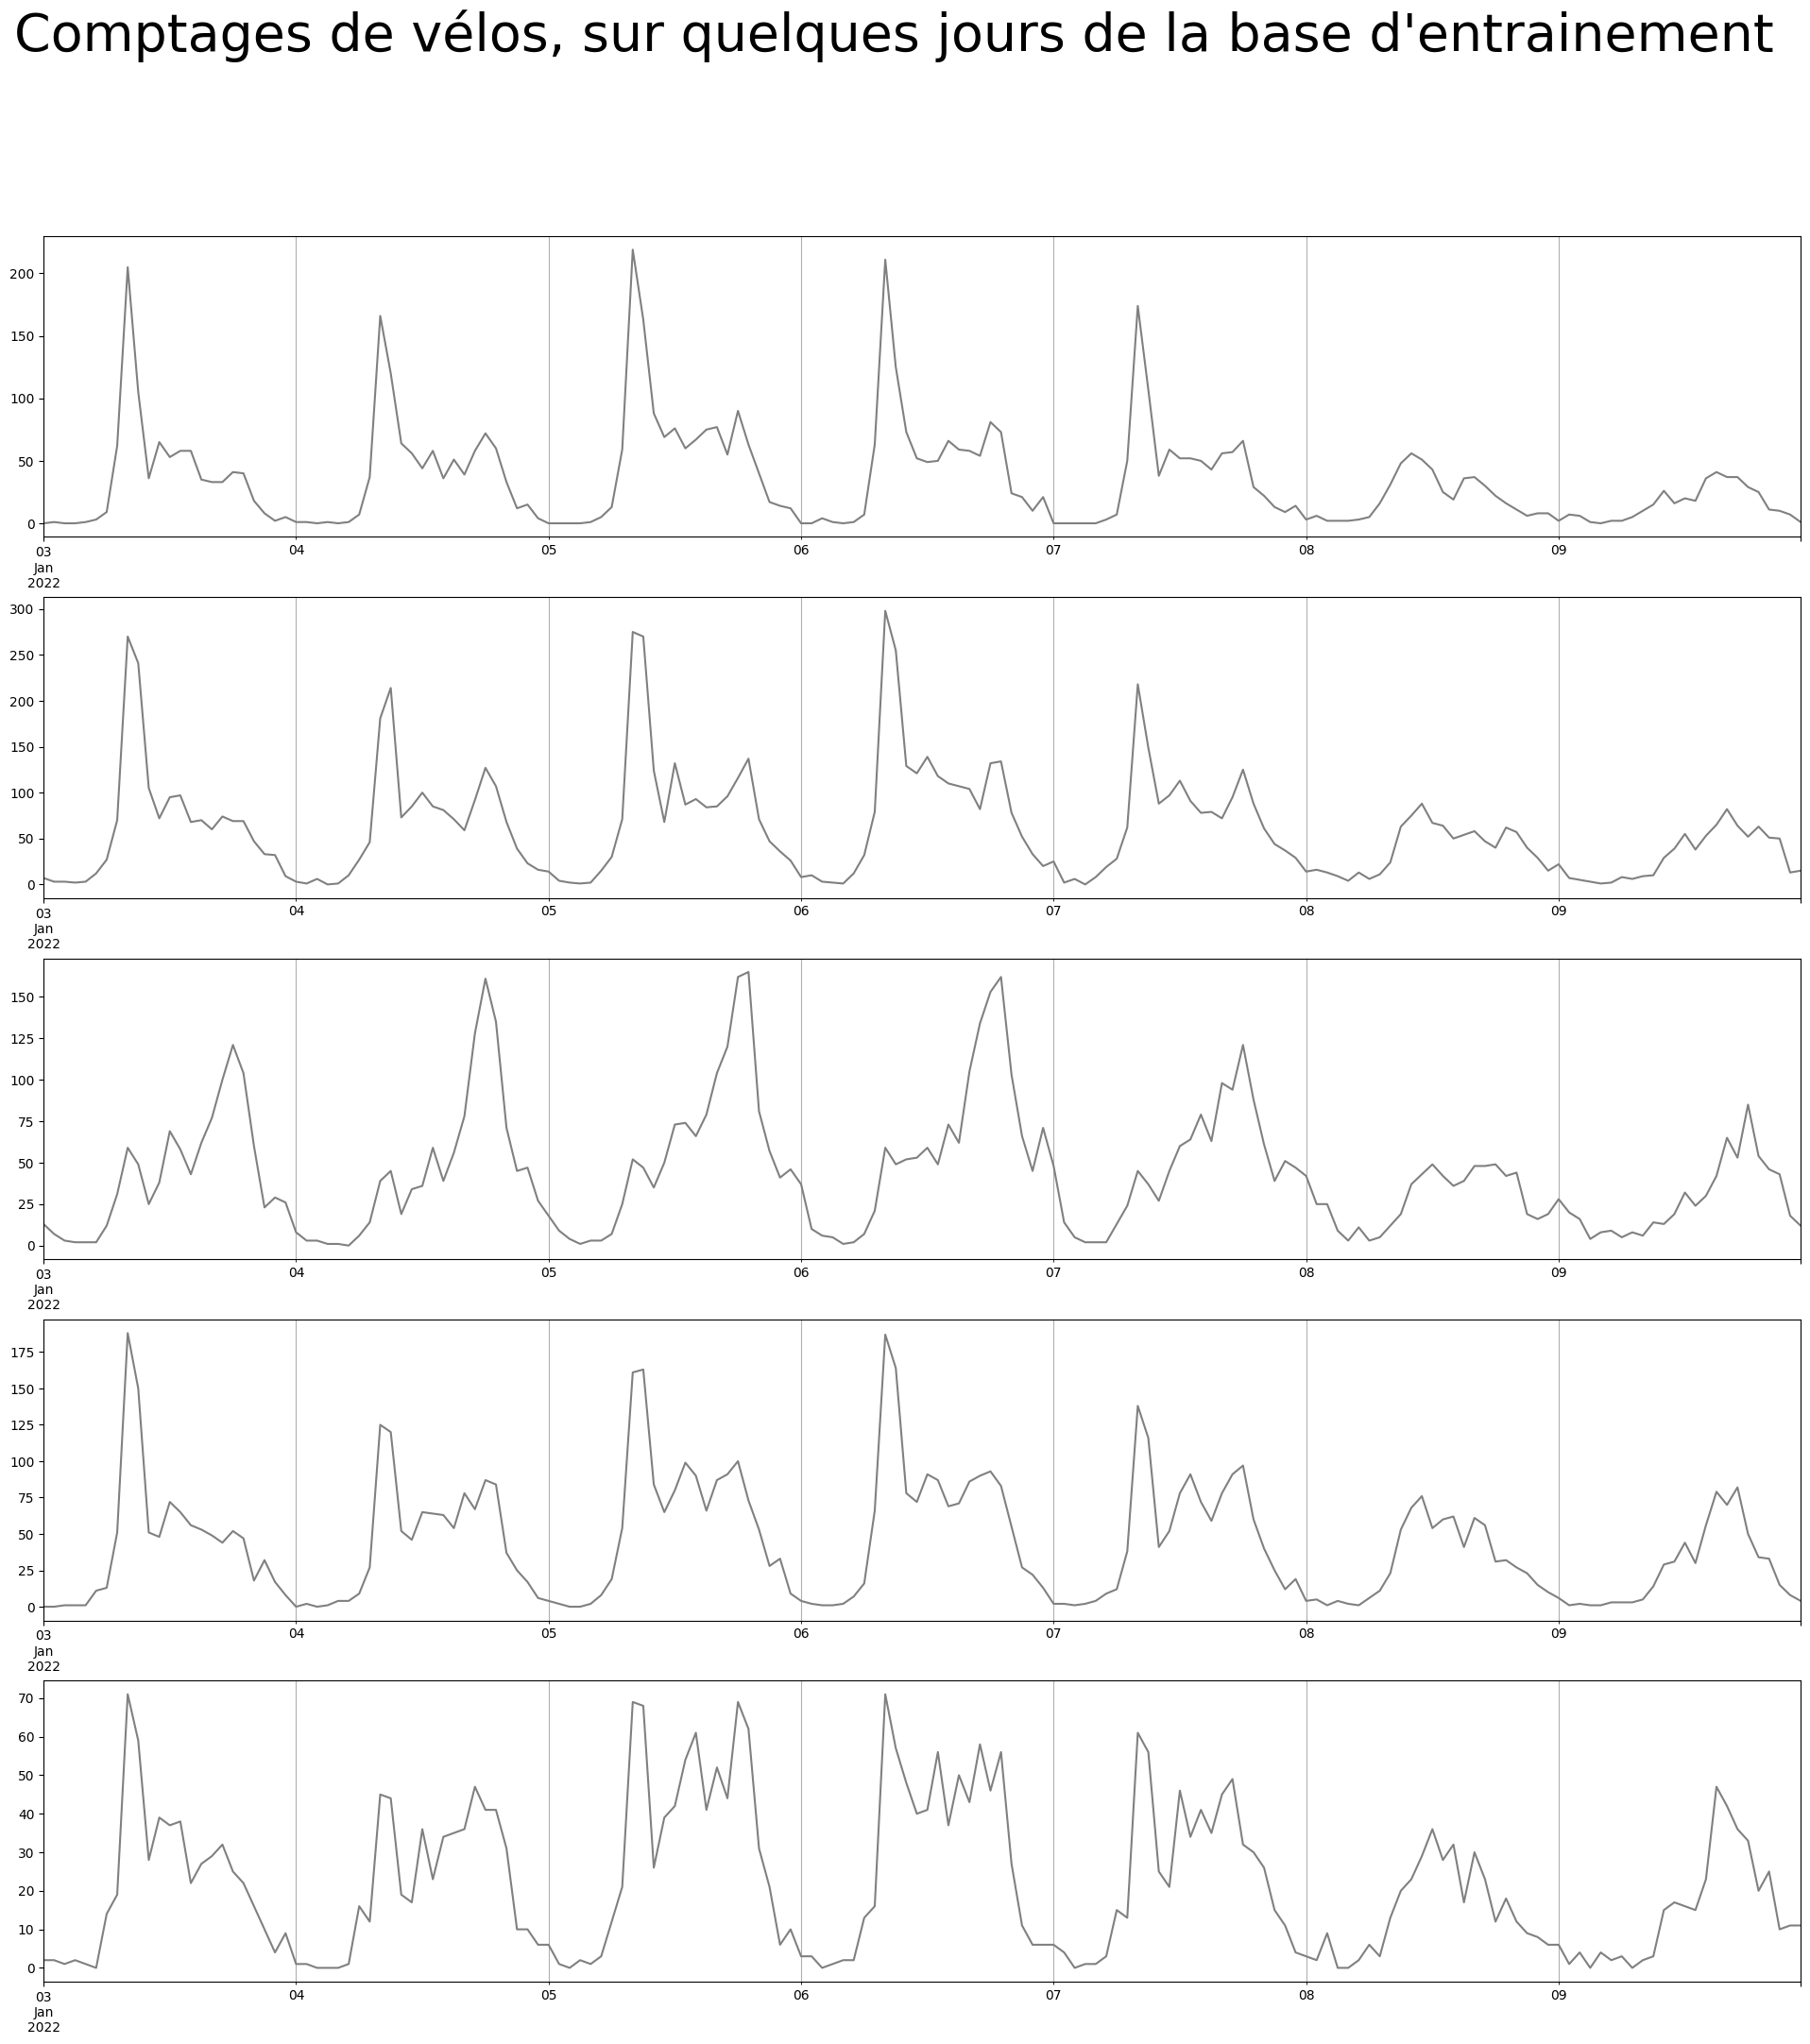

In [ ]:
##Elicitation du nombre de séries et du nombre de jours que l'on souhaite visualiser (MODIFIABLE)
n_jours = 7
n_series = 5

##On remet en forme les données sous forme de dataframes pour la visualisation

#Entrainement
target = train_ds[0]['target'].T
start = train_ds[0]['start']
periods = target.shape[0]
index = pd.date_range(start=start.strftime('%Y-%m-%d %H:%M:%S'), periods=periods, freq=start.freq)
series_train = pd.DataFrame(target, index=index)

#Test
target = test_ds[0]['target'].T
start = test_ds[0]['start']
periods = target.shape[0]
index = pd.date_range(start=start.strftime('%Y-%m-%d %H:%M:%S'), periods=periods, freq=start.freq)
series_test = pd.DataFrame(target, index=index)

##Création des subplots dans lesquels seront représentés les graphiques
label_prefix = ""
rows = n_series
cols = 1
fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
fig.suptitle('Comptages de vélos, sur quelques jours de la base d\'entrainement', fontsize=40)
axx = axs
                  
for dim in range(0, int((rows*cols))):
    ax = axx[dim]
    ax.grid(which="both")
    series_train[:(n_jours)*prediction_length][dim].plot(ax=ax, color = 'grey') 

Nous remarquons deux éléments sur ces séries :


1.   Les jours de semaine et les jours de weekend ont des profils bien différents. Les jours de semaine présentent ainsi des oics de fréquentation que l'on ne voit pas le weekend.
2.   Ces pics de fréquentation peuvent se trouver le matin pour certains capteurs, ou le soir pour d'autres. Ce phénomène doit provenir directement de la situation des capteurs dans la ville : certains proches des zones de fort passage le matin, d'autres proches des zones de fort passage le soir.

Nous pouvons également visualiser quelques fenêtres glissantes pour nous faire une idée des différentes fréquentations que l'on aura à prédire. Là encore vous pouvez modifier le nombre de séries que vous souhaitez visualiser (n_series).


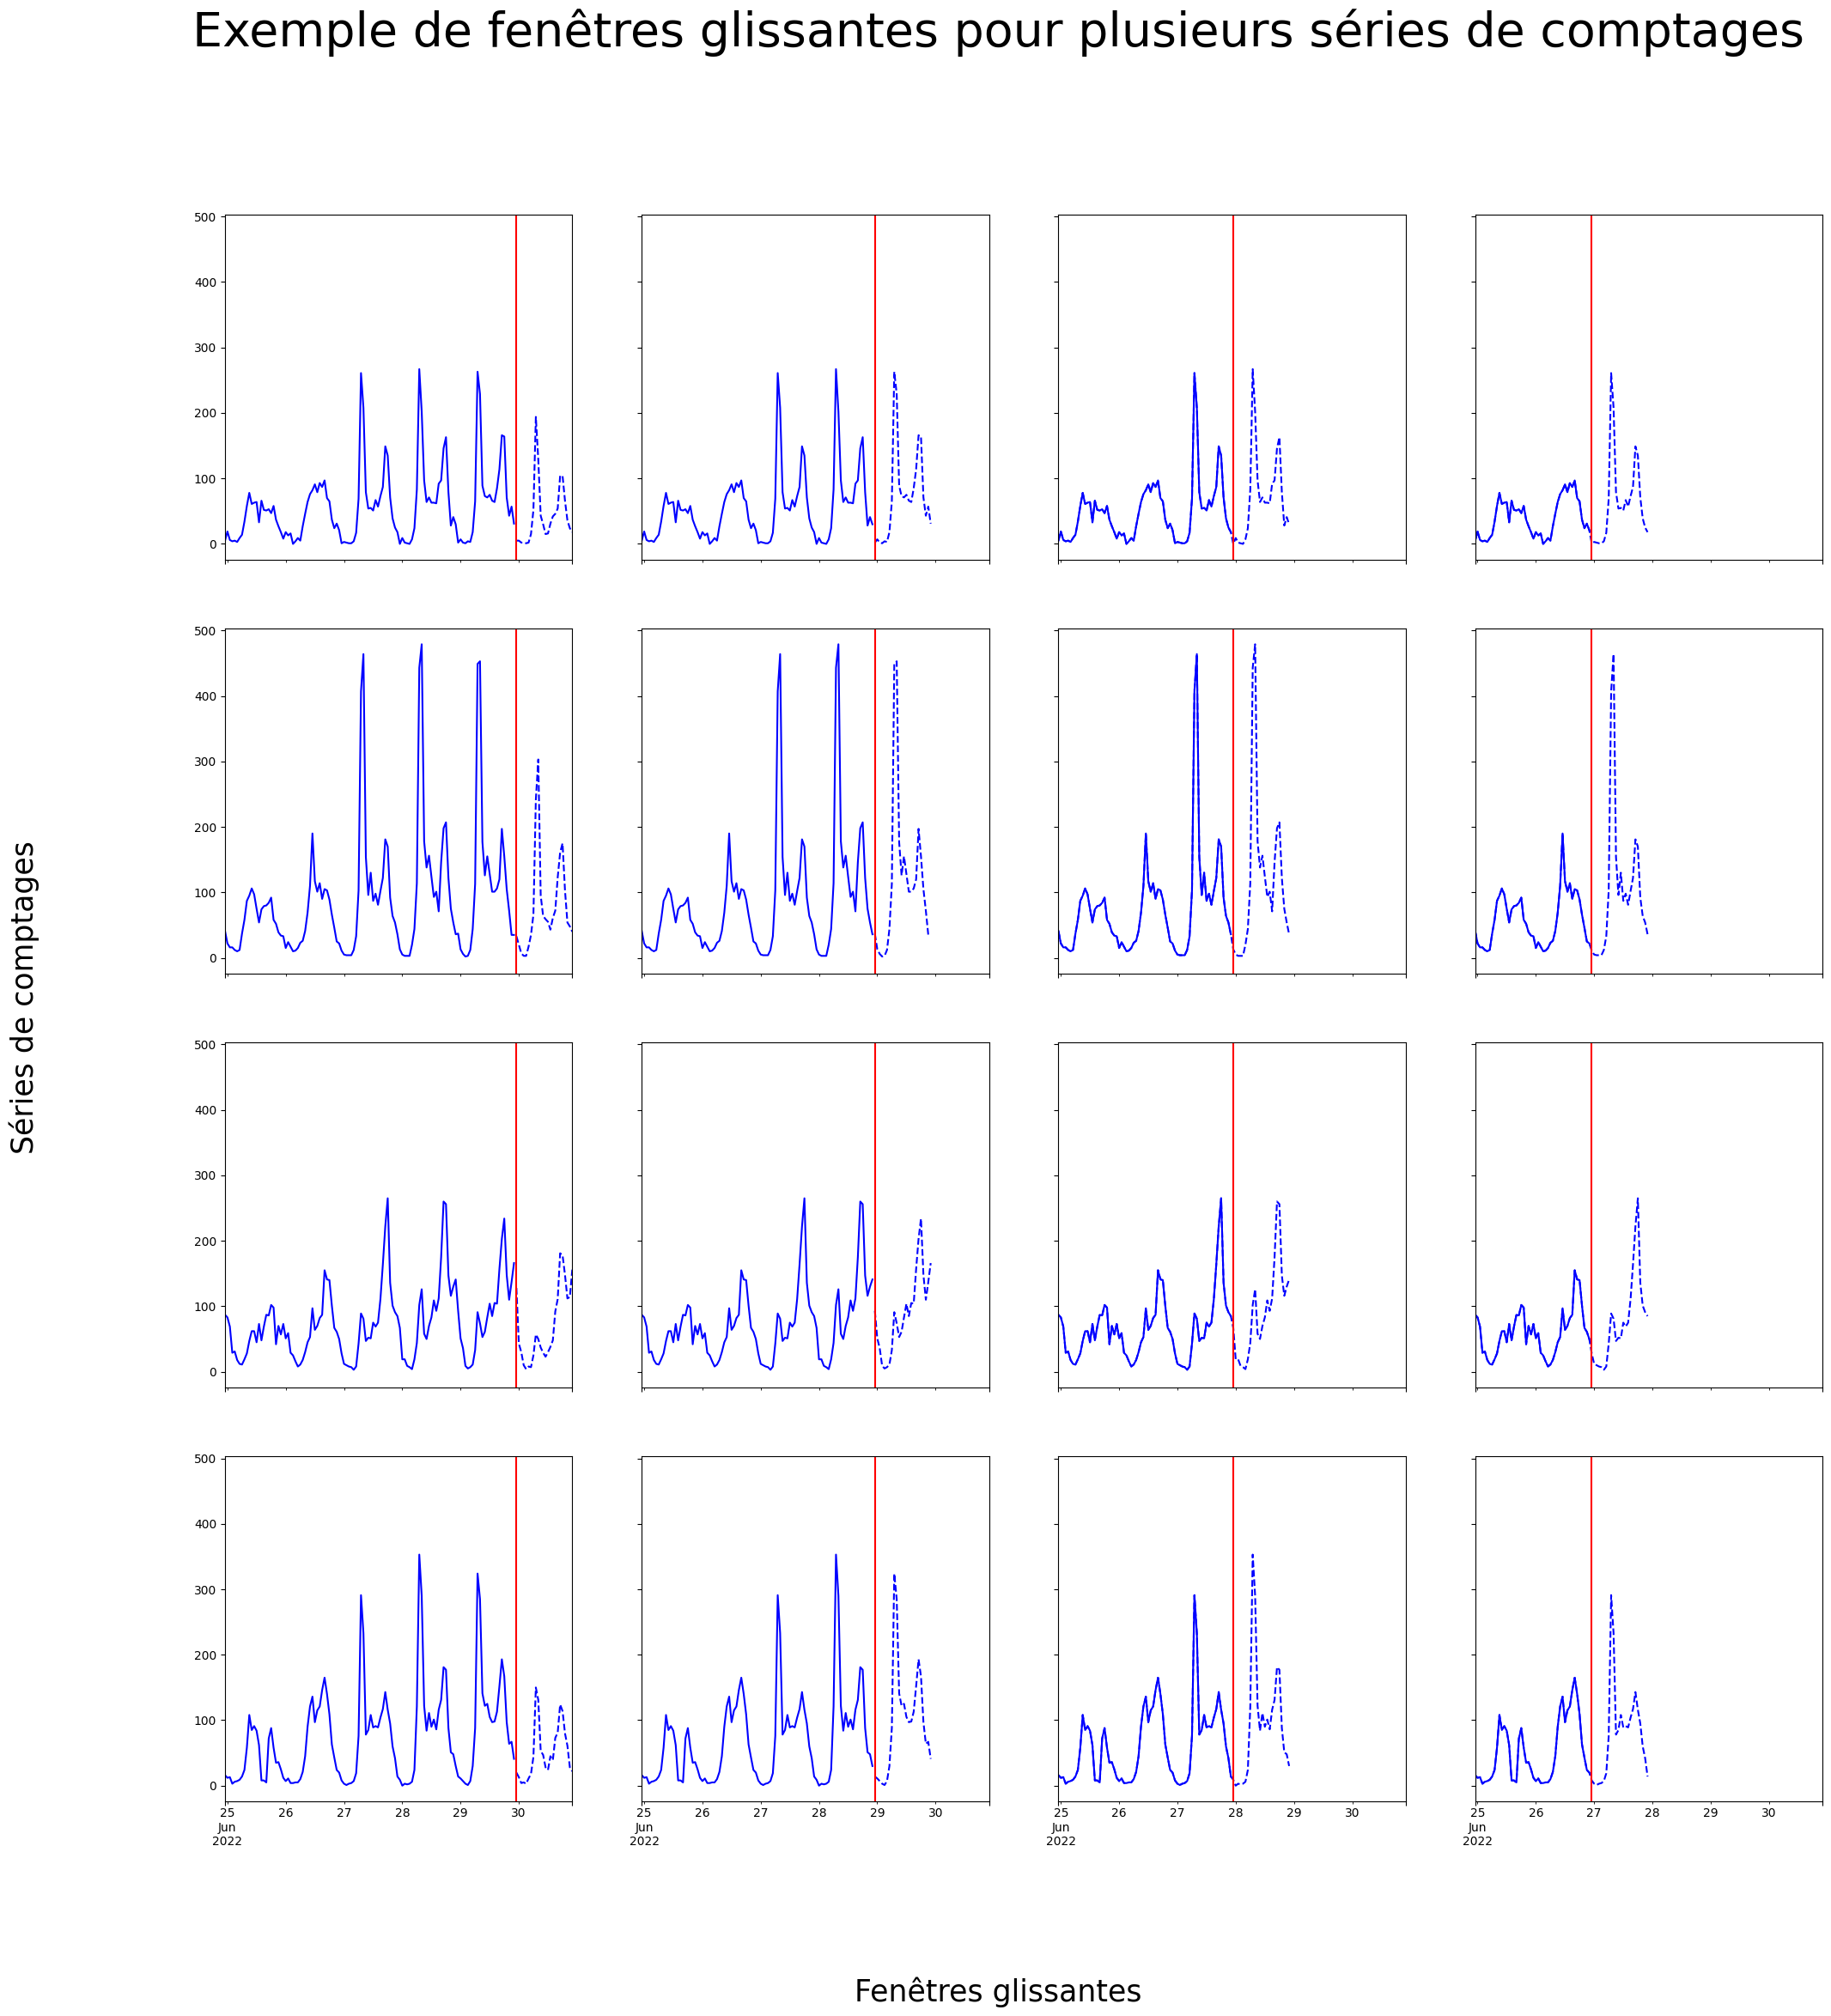

In [ ]:
#Nombre de séries que l'on visualisera
n_series = 4

label_prefix = ""
rows = n_series
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(24, 24), sharex=True, sharey=True)

fig.supxlabel('Fenêtres glissantes', fontsize=25)
fig.supylabel('Séries de comptages', fontsize=25)

fig.suptitle('Exemple de fenêtres glissantes pour plusieurs séries de comptages', fontsize=40)
axx = axs

                  
for dim in range(0, rows):
    ax3 = axx[dim, 3]
    series_test[-(6*prediction_length):-(4*prediction_length)][dim].plot(ax=ax3, color = 'blue')
    series_test[-(6*prediction_length):-(3*prediction_length)][dim].plot(ax=ax3, color = 'blue', linestyle='dashed')
    ax3.axvline(series_test.index[-(4*prediction_length)], color="r")
    
    ax2 = axx[dim, 2]
    series_test[-(6*prediction_length):-(3*prediction_length)][dim].plot(ax=ax2, color = 'blue')
    series_test[-(6*prediction_length):-(2*prediction_length)][dim].plot(ax=ax2, color = 'blue', linestyle='dashed')
    ax2.axvline(series_test.index[-(3*prediction_length)], color="r")
    
    ax1 = axx[dim, 1]
    series_test[-(6*prediction_length):-(2*prediction_length)][dim].plot(ax=ax1, color = 'blue')
    series_test[-(2*prediction_length):-prediction_length][dim].plot(ax=ax1, color = 'blue', linestyle='dashed')
    ax1.axvline(series_test.index[-(2*prediction_length)], color="r")
    
    ax0 = axx[dim, 0]
    series_test[-(6*prediction_length):-prediction_length][dim].plot(ax=ax0, color = 'blue')
    series_test[-prediction_length:][dim].plot(ax=ax0, color = 'blue', linestyle='dashed')
    ax0.axvline(series_test.index[-prediction_length], color="r")

Cette figure montre un exemple de 4 fenêtres glissantes, visualisées pour *n_series* séries de comptages. On prédit par exemple la dernière journée de juin, puis le 29 juin, puis le 28, ...

# Entraînement d'un modèle de prédiction DeepVAR simple (pas d'utilisation de matrice de faible rang, simple mise à l'échelle des données en entrée)

Maintenant nous voulons apprendre un modèle de prédiction sur les données de la base d'entraînement. Pour commencer nous allons travailler avec un modèle DeepVAR pour lequel il n'y a pas de transformation des données en entrée par Copules gaussiennes et qui n'utilise pas de matrice de faible rang. 

Commençons par éliciter le modèle et ses différentes options. Nous allons choisir un entrainement sur 3 epochs avec 10 batches par epoch. Nous allons également spécifier un dropout à 0.01 et un taux d'apprentissage à 10-3. Nous utilisons des lags à 1, 2, 12 et 24 heures pour le modèle autorégressif.

In [ ]:
estimator = DeepVAREstimator(
            target_dim=target_dim,
            dropout_rate=0.01,
            prediction_length=prediction_length,
            cell_type="lstm",
            lags_seq = [1, 2, 12, 24],
            conditioning_length = 50,
            scaling=True,
            freq=freq,
            use_marginal_transformation=False,
            distr_output=MultivariateGaussianOutput(dim = target_dim),
            trainer=Trainer(
         epochs=3,
         learning_rate=1e-3,
         num_batches_per_epoch=10),
        )

Une fois l'object "estimator" crée, nous pouvons lancer l'entraînement avec les options précisées. Avec 3 epochs, celui ci devrait aller assez vite.

In [ ]:
predictor = estimator.train(train_ds)

100%|██████████| 10/10 [00:19<00:00,  1.92s/it, epoch=10/10, avg_epoch_loss=316]


Voilà le modèle a été entraîné comme il faut. Vous constaterez que la loss (la -log vraisemblance) a diminué à chaque epoch, ce qui souligne qu'un apprentissage a bien eu lieu. 

Maintenant nous voulons regarder quelques statistiques de prédiction sur la base de prédiction. Pour cela des métriques (CRPS, MAPE, etc..) peuvent être calculées et moyennées sur l'ensemble des fenêtres de la base de prédiction. Pour lancer les prédictions, on peut utiliser la commande *make_evaluation_prediction* de Gluonts, elle peut prendre quelques dizaines de secondes à quelques minutes selon la taille des données et le nombre de répétitions. Pour nous cela devrait aller assez vite. Nous allons spécifier que nous répétons 30 fois chaque prédictions our calculer des quantiles de prédictions.

In [ ]:
#Prédictions sur fenêtres glissantes
forecast_it, ts_it = make_evaluation_predictions(
                test_ds, predictor=predictor, num_samples=30
            )

forecasts = list(forecast_it)
targets = list(ts_it)

Assurons nous de la dimension des objets crées lors de la prédiction, par exemple sur la dernière fenêtre.

In [ ]:
forecast_entry = forecasts[-1]
print(f"Nombre de répétitions de prédictions: {forecast_entry.num_samples}")
print(f"Dimension des prédictions pour la fenêtre: {forecast_entry.samples.shape}")
print(f"Date de départ de la fenêtre: {forecast_entry.start_date}")
print(f"Fréquence de la série temporelle: {forecast_entry.freq}")

Nombre de répétitions de prédictions: 30
Dimension des prédictions pour la fenêtre: (30, 24, 80)
Date de départ de la fenêtre: 2022-05-31 23:00
Fréquence de la série temporelle: <Hour>


Calculons nos métriques d'évaluation maintenant.

In [ ]:
# Evaluation
evaluator = MultivariateEvaluator(
                    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={'sum': np.sum}
                )

agg_metric, item_metrics = evaluator(
                    targets, forecasts, num_series=len(test_ds)
                )

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("MSE: {}".format(agg_metric['MSE']))
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))

Running evaluation: 30it [00:00, 76.31it/s]
Running evaluation: 30it [00:00, 74.77it/s]
Running evaluation: 30it [00:00, 73.93it/s]
Running evaluation: 30it [00:00, 77.11it/s]
Running evaluation: 30it [00:00, 72.21it/s]
Running evaluation: 30it [00:00, 78.23it/s]
Running evaluation: 30it [00:00, 71.05it/s]
Running evaluation: 30it [00:00, 74.45it/s]
Running evaluation: 30it [00:00, 55.87it/s]
Running evaluation: 30it [00:00, 75.68it/s]
Running evaluation: 30it [00:00, 69.27it/s]
Running evaluation: 30it [00:00, 72.98it/s]
Running evaluation: 30it [00:00, 70.55it/s]
Running evaluation: 30it [00:00, 73.73it/s]
Running evaluation: 30it [00:00, 65.19it/s]
Running evaluation: 30it [00:00, 75.39it/s]
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.9/dist-packages/gluonts/evaluation/_base.py:513: RuntimeWarning: divide by zero encountered in double_sc

CRPS: 0.6424222525245593
MSE: 14310.197322086096
CRPS-Sum: 0.6177849314298997


A vous de jouer maintenant ! Lancez l'apprentissage du même modèle DeepVAR précédent mais sur davantage d'epochs cette fois (par exemple 10). Que constatez vous ? Y a t-il une amélioration ou non des métriques calculées (CRPS, MSE) ? 

Une fois cette petite expérience effectuée nous allons étudier un autre modèle, potentiellement plus robuste.

# Modèle DeepVAR avec transformation des données par copules guaussiennes en entrée et utilisation d'une matrice de faible rang. 